#### We are focusing on Commericial Real Estate Properties in New York City

In [13]:
# Import Libraries

import pandas as pd
import numpy as np

In [14]:
df = pd.read_csv("assets/nyc-rolling-sales.csv")

df.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [15]:
for category in df['BUILDING CLASS CATEGORY'].unique():
    count = df[df['BUILDING CLASS CATEGORY'] == category].shape[0]
    print(f"{category}: {count}")

07 RENTALS - WALKUP APARTMENTS             : 3466
08 RENTALS - ELEVATOR APARTMENTS           : 382
09 COOPS - WALKUP APARTMENTS               : 2767
10 COOPS - ELEVATOR APARTMENTS             : 12902
11A CONDO-RENTALS                           : 43
12 CONDOS - WALKUP APARTMENTS              : 926
13 CONDOS - ELEVATOR APARTMENTS            : 12989
14 RENTALS - 4-10 UNIT                     : 671
15 CONDOS - 2-10 UNIT RESIDENTIAL          : 1281
16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT : 96
17 CONDO COOPS                             : 1201
22 STORE BUILDINGS                         : 935
37 RELIGIOUS FACILITIES                    : 100
42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC  : 13
46 CONDO STORE BUILDINGS                   : 154
47 CONDO NON-BUSINESS STORAGE              : 377
01 ONE FAMILY DWELLINGS                    : 18235
02 TWO FAMILY DWELLINGS                    : 15828
03 THREE FAMILY DWELLINGS                  : 4384
04 TAX CLASS 1 CONDOS                      : 1656
21 OFFIC

In [24]:
# Clean and convert sale prices
# First, replace all variations of '-' with NaN
df['SALE PRICE'] = df['SALE PRICE'].replace({'-': np.nan, ' -  ': np.nan, ' - ': np.nan})

# Remove any leading/trailing spaces
df['SALE PRICE'] = df['SALE PRICE'].str.strip()

# Convert to numeric
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

# Create clean dataset
df_clean = df.dropna(subset=['SALE PRICE'])

# Convert SALE DATE to datetime
df_clean['SALE DATE'] = pd.to_datetime(df_clean['SALE DATE'])

# Check the results
print("Number of rows in cleaned dataset:", len(df_clean))
print("\nSale Price statistics:")
print(df_clean['SALE PRICE'].describe())

Number of rows in cleaned dataset: 69987

Sale Price statistics:
count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64


/var/folders/cx/mvftj85x3j1fx921tbjk0f9w0000gn/T/ipykernel_85503/3455701414.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SALE DATE'] = pd.to_datetime(df_clean['SALE DATE'])


In [26]:
# Convert GROSS SQUARE FEET and LAND SQUARE FEET to numeric
df_clean['GROSS SQUARE FEET'] = pd.to_numeric(df_clean['GROSS SQUARE FEET'].replace('-', np.nan), errors='coerce')
df_clean['LAND SQUARE FEET'] = pd.to_numeric(df_clean['LAND SQUARE FEET'].replace('-', np.nan), errors='coerce')

# Now calculate price per square foot for properties with valid square footage
df_clean['PRICE_PER_SQFT'] = df_clean['SALE PRICE'] / df_clean['GROSS SQUARE FEET']

# Remove infinite values and nulls
df_clean = df_clean[df_clean['PRICE_PER_SQFT'].notna() & (df_clean['PRICE_PER_SQFT'] != np.inf)]

# Remove extreme values using percentiles
q1 = df_clean['PRICE_PER_SQFT'].quantile(0.01)
q3 = df_clean['PRICE_PER_SQFT'].quantile(0.99)
df_clean = df_clean[
    (df_clean['PRICE_PER_SQFT'] >= q1) & 
    (df_clean['PRICE_PER_SQFT'] <= q3)
]

# Let's see the results
print("Summary statistics for Price per Square Foot:")
print(df_clean['PRICE_PER_SQFT'].describe())

# And basic statistics by borough
borough_stats = df_clean.groupby('BOROUGH').agg({
    'PRICE_PER_SQFT': ['count', 'mean', 'median'],
    'SALE PRICE': ['mean', 'median']
}).round(2)

print("\nStats by Borough:")
print(borough_stats)

Summary statistics for Price per Square Foot:
count    28029.000000
mean       392.604045
std        229.129093
min          4.705882
25%        244.590781
50%        348.684211
75%        488.663018
max       1722.059411
Name: PRICE_PER_SQFT, dtype: float64

Stats by Borough:
        PRICE_PER_SQFT                   SALE PRICE           
                 count    mean  median         mean     median
BOROUGH                                                       
1                  742  727.70  685.66  16587815.32  5887500.0
2                 3381  240.74  222.22   1043473.66   490000.0
3                 8244  451.96  401.10   1473819.70   875000.0
4                10741  404.25  382.43    913380.28   645000.0
5                 4921  321.57  311.20    540004.52   490000.0


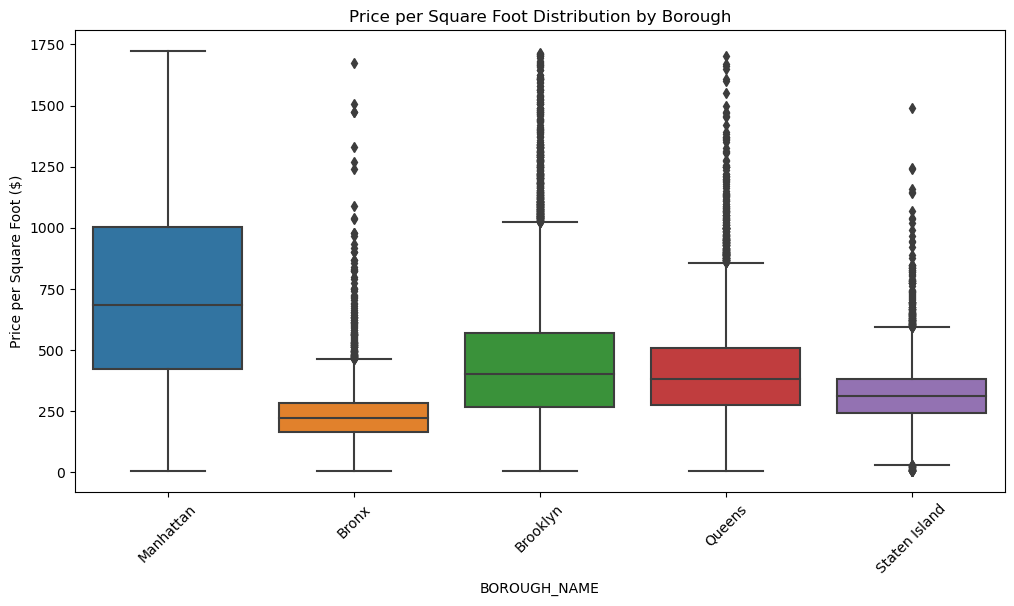


Borough Summary Statistics:
               Number of Sales  Avg Price/SqFt  Median Price/SqFt  \
BOROUGH_NAME                                                        
Bronx                     3381          240.74             222.22   
Brooklyn                  8244          451.96             401.10   
Manhattan                  742          727.70             685.66   
Queens                   10741          404.25             382.43   
Staten Island             4921          321.57             311.20   

               Std Dev Price/SqFt  Avg Sale Price  Median Sale Price  
BOROUGH_NAME                                                          
Bronx                      129.05      1043473.66           490000.0  
Brooklyn                   268.85      1473819.70           875000.0  
Manhattan                  412.56     16587815.32          5887500.0  
Queens                     191.50       913380.28           645000.0  
Staten Island              129.72       540004.52           4

In [28]:
# Create borough mapping
borough_mapping = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

# Create a new column with borough names
df_clean['BOROUGH_NAME'] = df_clean['BOROUGH'].map(borough_mapping)

# Now let's create a more informative visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='BOROUGH_NAME', y='PRICE_PER_SQFT', data=df_clean)
plt.title('Price per Square Foot Distribution by Borough')
plt.xticks(rotation=45)
plt.ylabel('Price per Square Foot ($)')
plt.show()

# Let's also create a summary table with formatted numbers
borough_summary = df_clean.groupby('BOROUGH_NAME').agg({
    'PRICE_PER_SQFT': ['count', 'mean', 'median', 'std'],
    'SALE PRICE': ['mean', 'median']
}).round(2)

# Rename columns for clarity
borough_summary.columns = [
    'Number of Sales',
    'Avg Price/SqFt',
    'Median Price/SqFt',
    'Std Dev Price/SqFt',
    'Avg Sale Price',
    'Median Sale Price'
]

print("\nBorough Summary Statistics:")
print(borough_summary)

# Let's also look at the total transaction value by borough
total_value_by_borough = df_clean.groupby('BOROUGH_NAME')['SALE PRICE'].sum() / 1e9  # Convert to billions
print("\nTotal Transaction Value by Borough (in billions):")
print(total_value_by_borough.round(2))

In [30]:
# Create a pivot table of average price per sqft by building type and borough
building_borough_analysis = df_clean.pivot_table(
    values='PRICE_PER_SQFT',
    index='BUILDING CLASS CATEGORY',
    columns='BOROUGH_NAME',
    aggfunc='mean'
).round(2)

print("Average Price/SqFt by Building Type and Borough:")
print(building_borough_analysis)

Average Price/SqFt by Building Type and Borough:
BOROUGH_NAME                               Bronx  Brooklyn  Manhattan  \
BUILDING CLASS CATEGORY                                                 
01 ONE FAMILY DWELLINGS                   288.91    512.18    1004.13   
02 TWO FAMILY DWELLINGS                   225.91    437.27     842.32   
03 THREE FAMILY DWELLINGS                 185.39    407.53     751.30   
05 TAX CLASS 1 VACANT LAND                   NaN    289.52        NaN   
06 TAX CLASS 1 - OTHER                     81.63    395.37        NaN   
07 RENTALS - WALKUP APARTMENTS            203.26    386.78     684.17   
08 RENTALS - ELEVATOR APARTMENTS          174.31    411.76     528.53   
09 COOPS - WALKUP APARTMENTS                 NaN       NaN     420.70   
10 COOPS - ELEVATOR APARTMENTS               NaN    408.94      21.49   
11 SPECIAL CONDO BILLING LOTS                NaN     20.00        NaN   
11A CONDO-RENTALS                            NaN       NaN     564.22   
14

In [31]:
# Calculate building age
df_clean['BUILDING_AGE'] = 2023 - df_clean['YEAR BUILT']

# Create age brackets
df_clean['AGE_BRACKET'] = pd.cut(df_clean['BUILDING_AGE'], 
                                bins=[0, 20, 40, 60, 80, 100, 200],
                                labels=['0-20 years', '21-40 years', '41-60 years', 
                                       '61-80 years', '81-100 years', '100+ years'])

# Average price by age bracket and borough
age_analysis = df_clean.pivot_table(
    values='PRICE_PER_SQFT',
    index='AGE_BRACKET',
    columns='BOROUGH_NAME',
    aggfunc='mean'
).round(2)

print("\nAverage Price/SqFt by Building Age and Borough:")
print(age_analysis)


Average Price/SqFt by Building Age and Borough:
BOROUGH_NAME   Bronx  Brooklyn  Manhattan  Queens  Staten Island
AGE_BRACKET                                                     
0-20 years    222.74    367.48     866.46  344.81         320.77
21-40 years   221.09    361.15     830.04  356.82         295.62
41-60 years   230.40    359.17     515.78  365.87         323.47
61-80 years   254.34    378.53     281.93  457.52         408.63
81-100 years  245.69    442.64     614.43  400.73         324.13
100+ years    235.96    493.53     757.44  377.78         276.48


In [32]:
# Create size categories based on gross square feet
df_clean['SIZE_CATEGORY'] = pd.qcut(df_clean['GROSS SQUARE FEET'], 
                                   q=5, 
                                   labels=['Very Small', 'Small', 'Medium', 
                                          'Large', 'Very Large'])

# Analysis by size
size_analysis = df_clean.groupby('SIZE_CATEGORY').agg({
    'PRICE_PER_SQFT': ['count', 'mean', 'median'],
    'SALE PRICE': ['mean', 'median'],
    'GROSS SQUARE FEET': ['mean', 'median']
}).round(2)

print("\nAnalysis by Property Size:")
print(size_analysis)


Analysis by Property Size:
              PRICE_PER_SQFT                  SALE PRICE             \
                       count    mean  median        mean     median   
SIZE_CATEGORY                                                         
Very Small              5646  453.66  416.67   481750.25   450000.0   
Small                   5579  397.59  361.15   576519.83   520000.0   
Medium                  5592  366.51  328.60   681900.11   610000.0   
Large                   5609  359.94  309.92   879004.56   748413.0   
Very Large              5603  384.86  301.46  4600107.93  1350000.0   

              GROSS SQUARE FEET          
                           mean  median  
SIZE_CATEGORY                            
Very Small              1074.36  1120.0  
Small                   1452.47  1440.0  
Medium                  1863.99  1857.0  
Large                   2443.80  2400.0  
Very Large             12342.54  3850.0  


In [33]:
# Select features for modeling
features = [
    'GROSS SQUARE FEET',
    'LAND SQUARE FEET',
    'BUILDING_AGE',
    'RESIDENTIAL UNITS',
    'COMMERCIAL UNITS',
    'TOTAL UNITS'
]

# Create dummy variables for categorical columns
categorical_features = ['BOROUGH_NAME', 'BUILDING CLASS CATEGORY', 'SIZE_CATEGORY']
df_model = pd.get_dummies(df_clean[features + categorical_features + ['PRICE_PER_SQFT']])

# Split features and target
X = df_model.drop('PRICE_PER_SQFT', axis=1)
y = df_model['PRICE_PER_SQFT']

print("\nFeatures prepared for modeling:")
print(X.columns.tolist())


Features prepared for modeling:
['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'BUILDING_AGE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'BOROUGH_NAME_Bronx', 'BOROUGH_NAME_Brooklyn', 'BOROUGH_NAME_Manhattan', 'BOROUGH_NAME_Queens', 'BOROUGH_NAME_Staten Island', 'BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS', 'BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS', 'BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS', 'BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND', 'BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER', 'BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS', 'BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS', 'BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS', 'BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS', 'BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS', 'BUILDING CLASS CATEGORY_11A CONDO-RENTALS', 'BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT', 'BUILDING CLASS CATEGORY_17 CONDO COOPS', 'BUILDING CLASS CATEGORY_21 OFFICE BUILDIN

In [34]:
# Calculate correlations with price
correlations = df_clean[features + ['PRICE_PER_SQFT']].corr()['PRICE_PER_SQFT'].sort_values(ascending=False)

print("\nCorrelations with Price per Square Foot:")
print(correlations)


Correlations with Price per Square Foot:
PRICE_PER_SQFT       1.000000
BUILDING_AGE         0.102123
COMMERCIAL UNITS    -0.000128
GROSS SQUARE FEET   -0.013782
TOTAL UNITS         -0.017661
RESIDENTIAL UNITS   -0.023801
LAND SQUARE FEET    -0.027199
Name: PRICE_PER_SQFT, dtype: float64


The correlations are surprisely weak, which suggests non-linear relationships and possibly that other factors like location and building type are more important, lets explore that

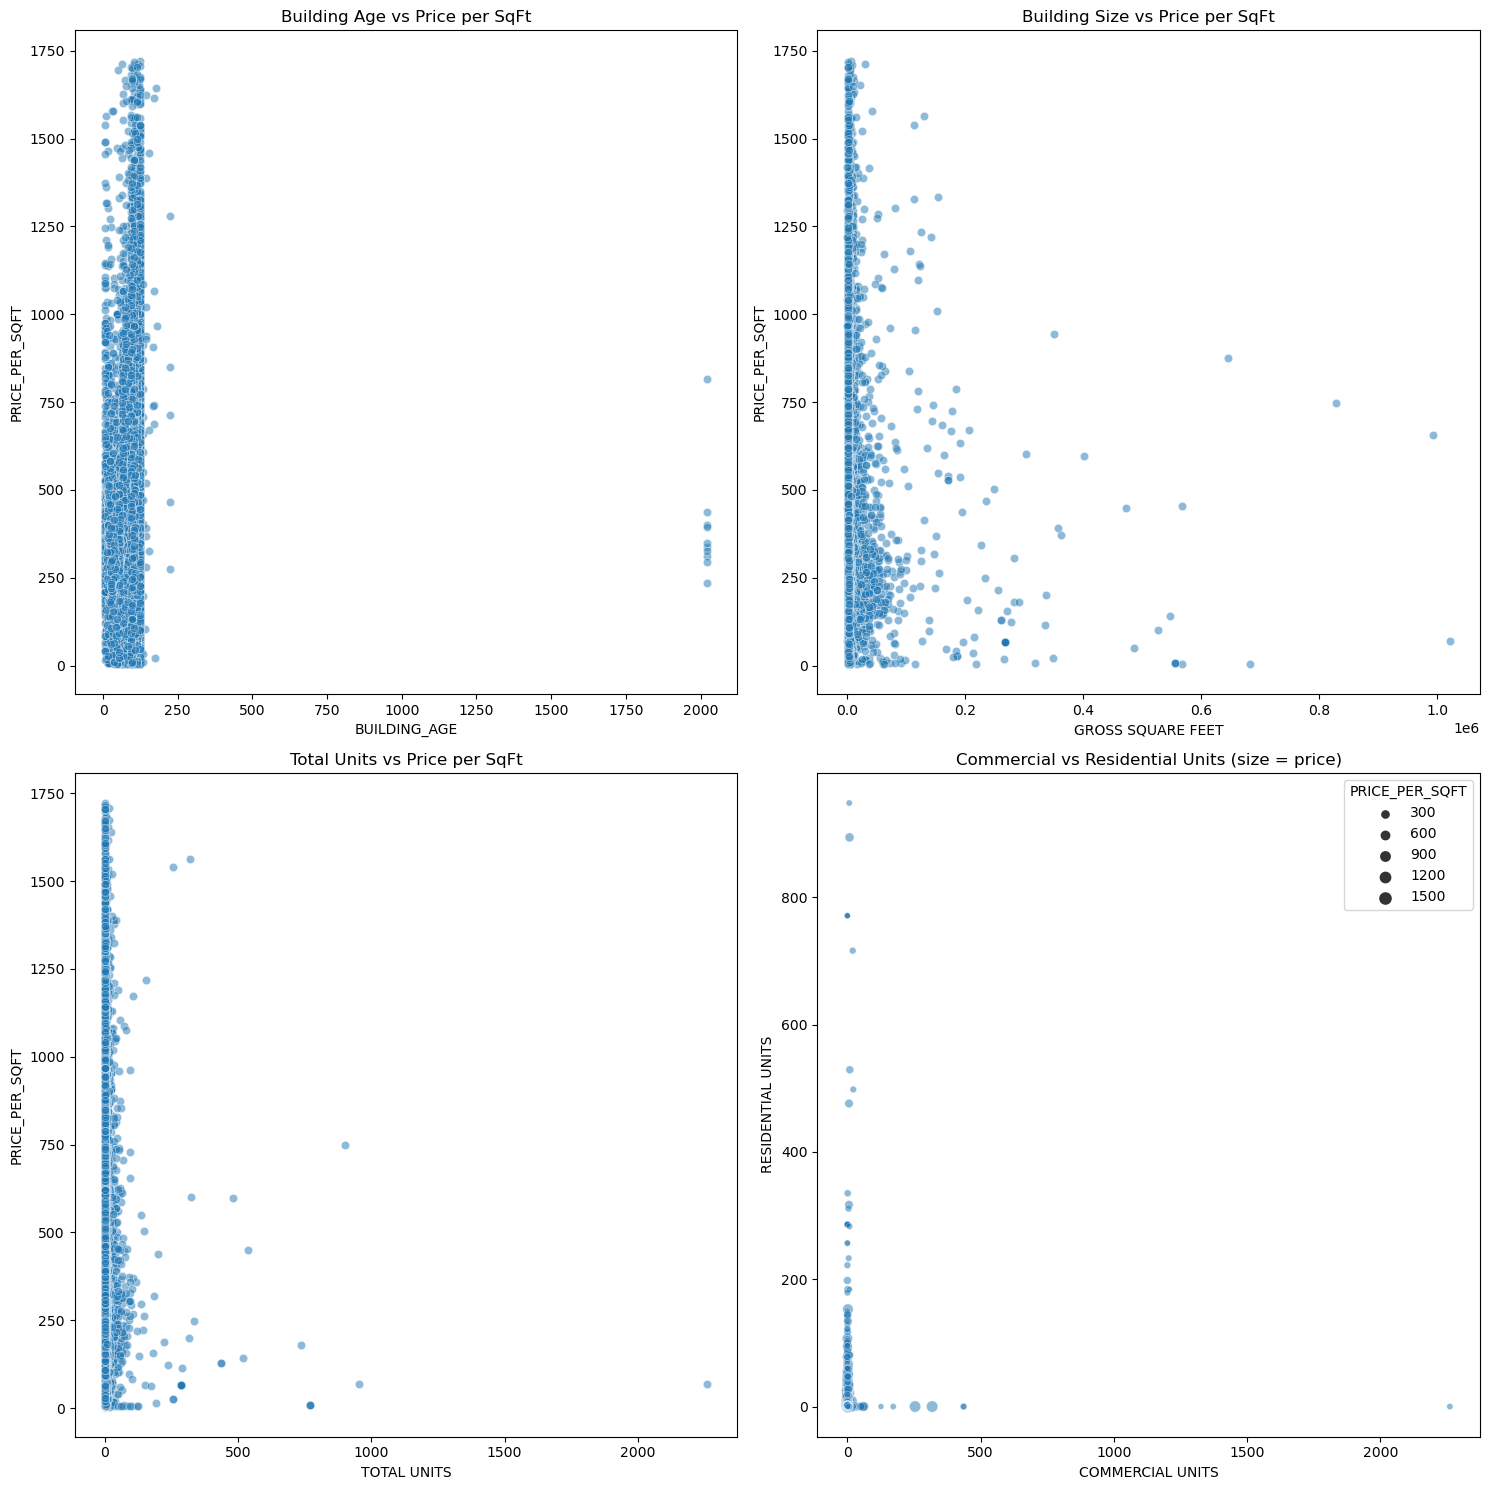

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Scatter plot of Building Age vs Price
sns.scatterplot(data=df_clean, x='BUILDING_AGE', y='PRICE_PER_SQFT', alpha=0.5, ax=axes[0,0])
axes[0,0].set_title('Building Age vs Price per SqFt')

# Scatter plot of Gross Square Feet vs Price
sns.scatterplot(data=df_clean, x='GROSS SQUARE FEET', y='PRICE_PER_SQFT', alpha=0.5, ax=axes[0,1])
axes[0,1].set_title('Building Size vs Price per SqFt')

# Scatter plot of Total Units vs Price
sns.scatterplot(data=df_clean, x='TOTAL UNITS', y='PRICE_PER_SQFT', alpha=0.5, ax=axes[1,0])
axes[1,0].set_title('Total Units vs Price per SqFt')

# Commercial vs Residential Units
sns.scatterplot(data=df_clean, x='COMMERCIAL UNITS', y='RESIDENTIAL UNITS', 
                size='PRICE_PER_SQFT', alpha=0.5, ax=axes[1,1])
axes[1,1].set_title('Commercial vs Residential Units (size = price)')

plt.tight_layout()
plt.show()


Correlations with Price per SqFt (transformed features):
PRICE_PER_SQFT     1.000000
BUILDING_AGE       0.102123
IS_MIXED_USE       0.021633
LOG_LAND_SQFT     -0.017647
LOG_TOTAL_UNITS   -0.023402
LOG_GROSS_SQFT    -0.058049
Name: PRICE_PER_SQFT, dtype: float64

Average Price per SqFt by Age Category:
AGE_CAT
New (0-20)              332.09
Modern (21-50)          313.45
Historic (51-100)       393.42
Very Historic (100+)    428.94
Name: PRICE_PER_SQFT, dtype: float64

Average Price per SqFt by Size Category:
SIZE_CAT
Very Small    453.66
Small         397.59
Medium        366.51
Large         359.94
Very Large    384.86
Name: PRICE_PER_SQFT, dtype: float64

Average Price per SqFt by Building Type:
BUILDING_TYPE
COMMERCIAL     467.18
OTHER          460.27
RESIDENTIAL    388.48
Name: PRICE_PER_SQFT, dtype: float64

Average Price per SqFt by Mixed Use:
IS_MIXED_USE
0    391.47
1    414.29
Name: PRICE_PER_SQFT, dtype: float64


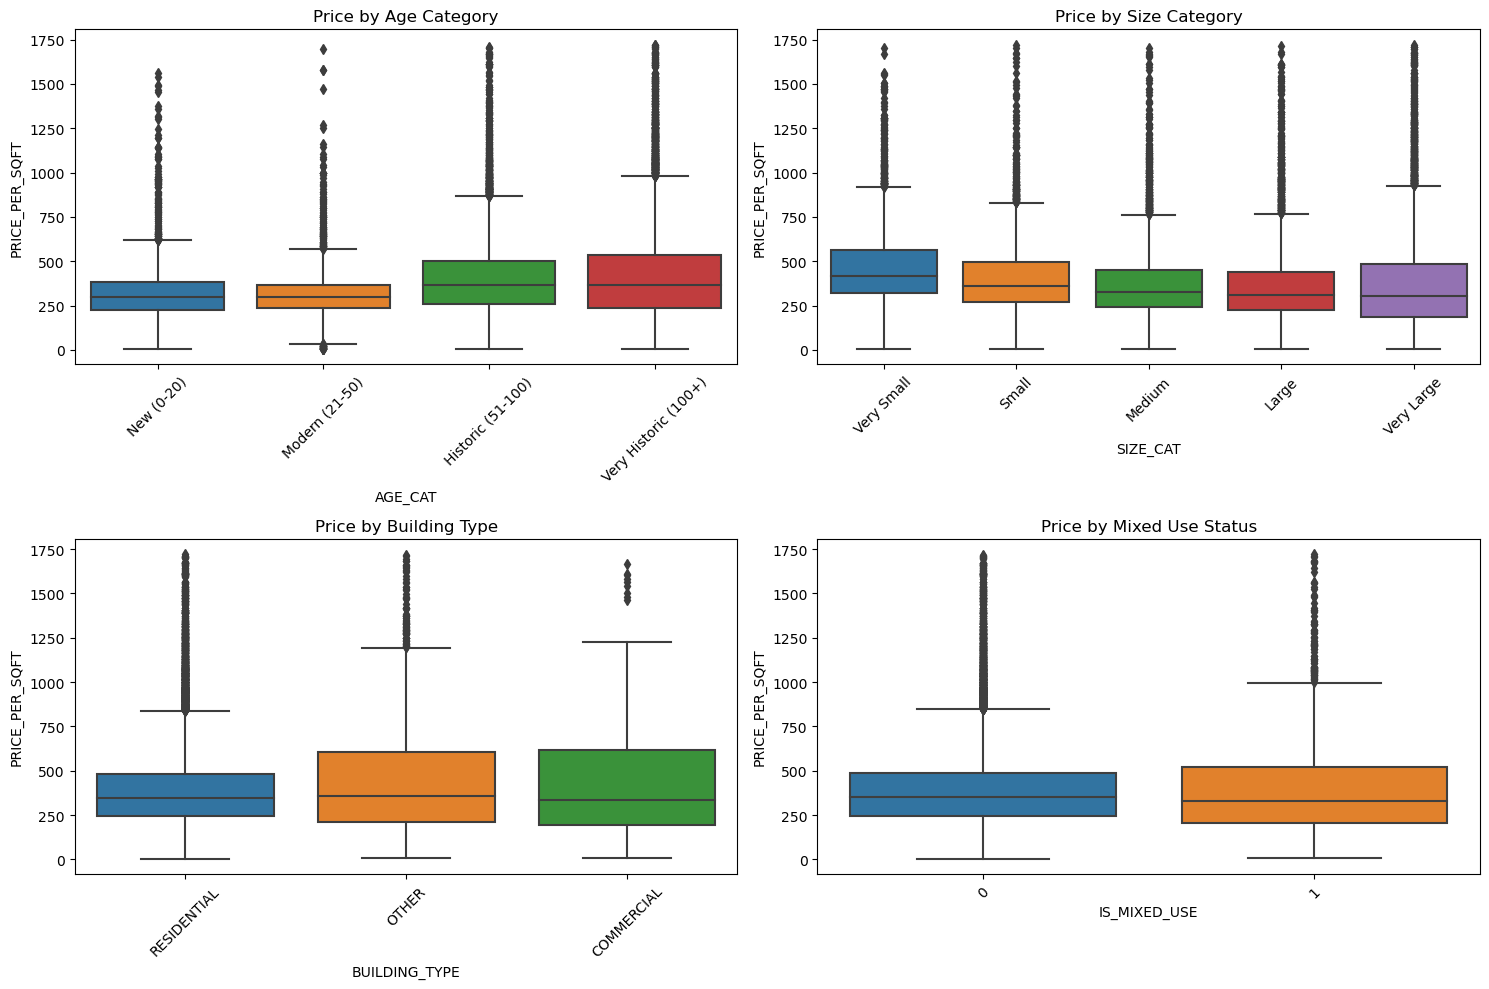

In [36]:
# 1. Create non-linear transformations and categorical features
df_model = df_clean.copy()

# Log transformations for continuous variables (adding 1 to handle zeros)
df_model['LOG_GROSS_SQFT'] = np.log1p(df_model['GROSS SQUARE FEET'])
df_model['LOG_LAND_SQFT'] = np.log1p(df_model['LAND SQUARE FEET'])
df_model['LOG_TOTAL_UNITS'] = np.log1p(df_model['TOTAL UNITS'])

# Age categories
df_model['AGE_CAT'] = pd.cut(df_model['BUILDING_AGE'], 
                            bins=[0, 20, 50, 100, 200],
                            labels=['New (0-20)', 'Modern (21-50)', 
                                   'Historic (51-100)', 'Very Historic (100+)'])

# Size categories based on log scale
df_model['SIZE_CAT'] = pd.qcut(df_model['GROSS SQUARE FEET'], 
                              q=5,
                              labels=['Very Small', 'Small', 'Medium', 
                                     'Large', 'Very Large'])

# Mixed use flag
df_model['IS_MIXED_USE'] = ((df_model['RESIDENTIAL UNITS'] > 0) & 
                           (df_model['COMMERCIAL UNITS'] > 0)).astype(int)

# Building type simplification (optional)
df_model['BUILDING_TYPE'] = df_model['BUILDING CLASS CATEGORY'].apply(
    lambda x: 'COMMERCIAL' if 'COMMERCIAL' in x.upper() 
    else ('RESIDENTIAL' if any(t in x.upper() for t in ['FAMILY', 'RESIDENTIAL', 'APARTMENT']) 
    else 'OTHER'))

# Let's see the correlations with these new features
new_features = ['LOG_GROSS_SQFT', 'LOG_LAND_SQFT', 'LOG_TOTAL_UNITS', 
                'BUILDING_AGE', 'IS_MIXED_USE', 'PRICE_PER_SQFT']

correlations = df_model[new_features].corr()['PRICE_PER_SQFT'].sort_values(ascending=False)
print("Correlations with Price per SqFt (transformed features):")
print(correlations)

# Let's analyze price patterns across these new categories
print("\nAverage Price per SqFt by Age Category:")
print(df_model.groupby('AGE_CAT')['PRICE_PER_SQFT'].mean().round(2))

print("\nAverage Price per SqFt by Size Category:")
print(df_model.groupby('SIZE_CAT')['PRICE_PER_SQFT'].mean().round(2))

print("\nAverage Price per SqFt by Building Type:")
print(df_model.groupby('BUILDING_TYPE')['PRICE_PER_SQFT'].mean().round(2))

print("\nAverage Price per SqFt by Mixed Use:")
print(df_model.groupby('IS_MIXED_USE')['PRICE_PER_SQFT'].mean().round(2))

# Visualize the relationships with these new features
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
sns.boxplot(x='AGE_CAT', y='PRICE_PER_SQFT', data=df_model)
plt.xticks(rotation=45)
plt.title('Price by Age Category')

plt.subplot(2,2,2)
sns.boxplot(x='SIZE_CAT', y='PRICE_PER_SQFT', data=df_model)
plt.xticks(rotation=45)
plt.title('Price by Size Category')

plt.subplot(2,2,3)
sns.boxplot(x='BUILDING_TYPE', y='PRICE_PER_SQFT', data=df_model)
plt.xticks(rotation=45)
plt.title('Price by Building Type')

plt.subplot(2,2,4)
sns.boxplot(x='IS_MIXED_USE', y='PRICE_PER_SQFT', data=df_model)
plt.xticks(rotation=45)
plt.title('Price by Mixed Use Status')

plt.tight_layout()
plt.show()